# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_t0_repeat.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

,Original Index,Condition,99.739764,104.250978,108.760014,113.264746,117.767305,122.267691,126.763784,131.255589,...,2470.400811,2473.565296,2476.728552,2479.888961,2483.049763,2486.209339,2489.366072,2492.523197,2495.677482,2498.827313
0,26,19,8807.0,9770.0,10275.0,9889.0,9158.0,8148.0,7535.0,6704.0,...,131.0,117.0,203.0,154.0,139.0,110.0,173.0,186.0,147.0,170.0
1,27,19,8794.0,10074.0,10352.0,9955.0,9132.0,8275.0,7304.0,6770.0,...,135.0,138.0,200.0,199.0,221.0,173.0,208.0,152.0,152.0,177.0
2,28,19,9149.0,10044.0,10476.0,9780.0,8925.0,8271.0,7495.0,6675.0,...,195.0,131.0,206.0,183.0,151.0,156.0,190.0,146.0,144.0,153.0
3,29,19,8838.0,10082.0,10433.0,9932.0,9173.0,8376.0,7239.0,6721.0,...,123.0,174.0,173.0,83.0,193.0,114.0,139.0,146.0,143.0,134.0
4,30,19,9004.0,10047.0,10478.0,10033.0,9329.0,8251.0,7429.0,6906.0,...,166.0,142.0,188.0,167.0,185.0,156.0,208.0,105.0,170.0,160.0
5,57,20,9011.0,10181.0,10401.0,10184.0,9325.0,8454.0,7476.0,6921.0,...,132.0,67.0,124.0,119.0,163.0,78.0,151.0,123.0,115.0,72.0
6,58,20,9028.0,10171.0,10336.0,9970.0,9212.0,8507.0,7622.0,6983.0,...,146.0,44.0,187.0,98.0,133.0,92.0,161.0,113.0,129.0,100.0
7,59,20,9182.0,10201.0,10513.0,9884.0,9246.0,8396.0,7629.0,6709.0,...,143.0,120.0,131.0,131.0,129.0,174.0,143.0,155.0,122.0,114.0
8,60,20,9092.0,9969.0,10636.0,9977.0,9204.0,8384.0,7476.0,7026.0,...,76.0,89.0,131.0,122.0,128.0,78.0,162.0,94.0,118.0,121.0
9,61,20,8799.0,10235.0,10497.0,9899.0,9187.0,8524.0,7712.0,6841.0,...,77.0,121.0,197.0,84.0,159.0,113.0,179.0,121.0,84.0,102.0


# Test Plots and Baseline Correction

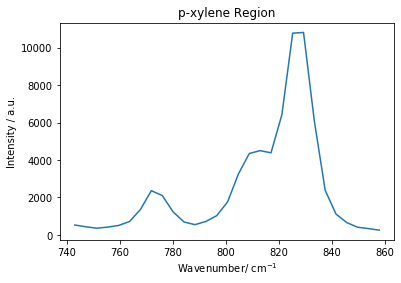

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

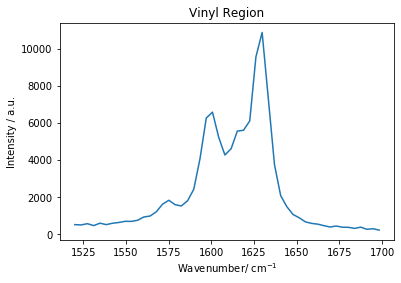

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

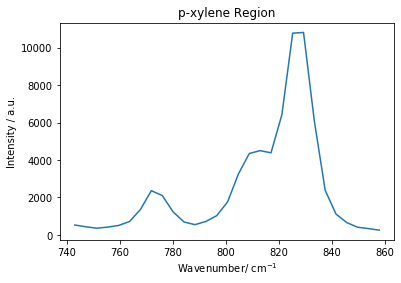

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(743.107581, 529.0),
 (747.235957, 437.0),
 (751.364423, 360.0),
 (755.490999, 418.0),
 (759.613705, 506.0),
 (845.650826, 659.0),
 (849.720613, 412.0),
 (853.788551, 340.0),
 (857.854643, 258.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

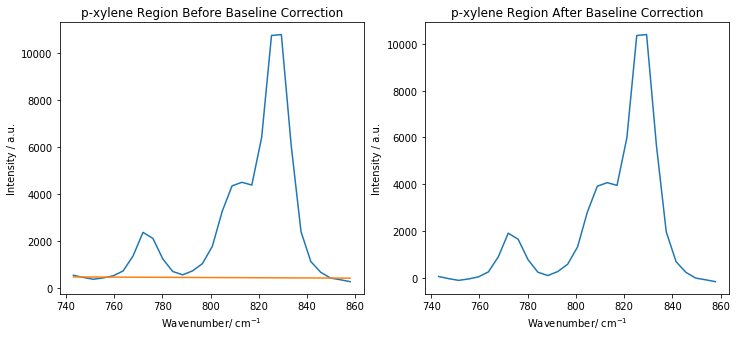

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

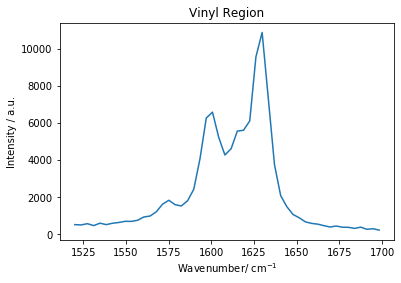

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1520.028312, 502.0),
 (1523.715956, 486.0),
 (1527.400209, 553.0),
 (1531.082889, 450.0),
 (1534.763995, 581.0),
 (1538.441718, 502.0),
 (1542.119683, 577.0),
 (1545.794267, 617.0),
 (1549.465474, 681.0),
 (1553.136926, 677.0),
 (1665.901972, 447.0),
 (1669.507884, 374.0),
 (1673.110491, 426.0),
 (1676.713364, 363.0),
 (1680.311155, 356.0),
 (1683.909212, 300.0),
 (1687.503974, 365.0),
 (1691.097223, 251.0),
 (1694.688961, 281.0),
 (1698.279189, 206.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

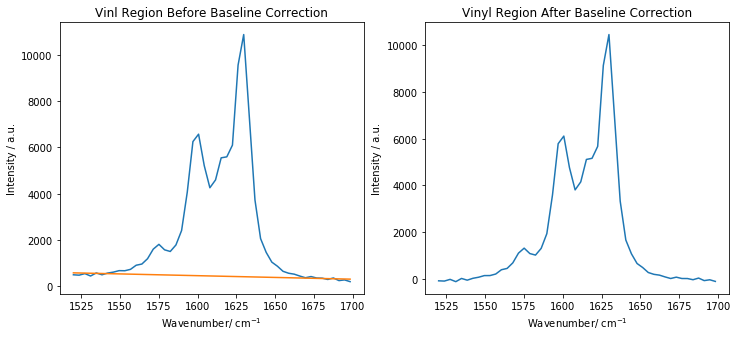

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

,1520.028312,1523.715956,1527.400209,1531.082889,1534.763995,1538.441718,1542.119683,1545.794267,1549.465474,1553.136926,...,1665.901972,1669.507884,1673.110491,1676.713364,1680.311155,1683.909212,1687.503974,1691.097223,1694.688961,1698.279189
0,502.0,486.0,553.0,450.0,581.0,502.0,577.0,617.0,681.0,677.0,...,447.0,374.0,426.0,363.0,356.0,300.0,365.0,251.0,281.0,206.0
1,499.0,523.0,514.0,545.0,556.0,566.0,534.0,641.0,685.0,656.0,...,533.0,377.0,420.0,436.0,368.0,311.0,340.0,340.0,229.0,270.0
2,572.0,480.0,547.0,492.0,574.0,531.0,640.0,567.0,622.0,638.0,...,460.0,431.0,394.0,324.0,364.0,287.0,330.0,230.0,224.0,215.0
3,492.0,498.0,536.0,475.0,544.0,547.0,545.0,615.0,617.0,653.0,...,497.0,414.0,396.0,370.0,384.0,294.0,333.0,279.0,301.0,211.0
4,472.0,545.0,470.0,493.0,563.0,549.0,595.0,650.0,683.0,691.0,...,467.0,439.0,432.0,346.0,390.0,323.0,289.0,289.0,262.0,220.0
5,363.0,409.0,440.0,435.0,566.0,466.0,540.0,591.0,669.0,678.0,...,478.0,371.0,401.0,260.0,260.0,188.0,321.0,221.0,199.0,168.0
6,448.0,428.0,405.0,424.0,543.0,465.0,534.0,604.0,692.0,647.0,...,407.0,375.0,352.0,304.0,284.0,231.0,240.0,201.0,234.0,147.0
7,438.0,447.0,474.0,514.0,503.0,492.0,560.0,596.0,615.0,663.0,...,470.0,444.0,328.0,320.0,356.0,234.0,255.0,205.0,218.0,199.0
8,430.0,406.0,451.0,418.0,441.0,446.0,546.0,564.0,628.0,625.0,...,474.0,409.0,382.0,256.0,278.0,252.0,268.0,227.0,225.0,133.0
9,448.0,405.0,459.0,493.0,500.0,493.0,550.0,586.0,604.0,647.0,...,417.0,398.0,338.0,285.0,348.0,233.0,277.0,233.0,250.0,140.0


For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 140000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 8

ampL2 = 180000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 5

## Fitting and Plotting (Vinyl Region)

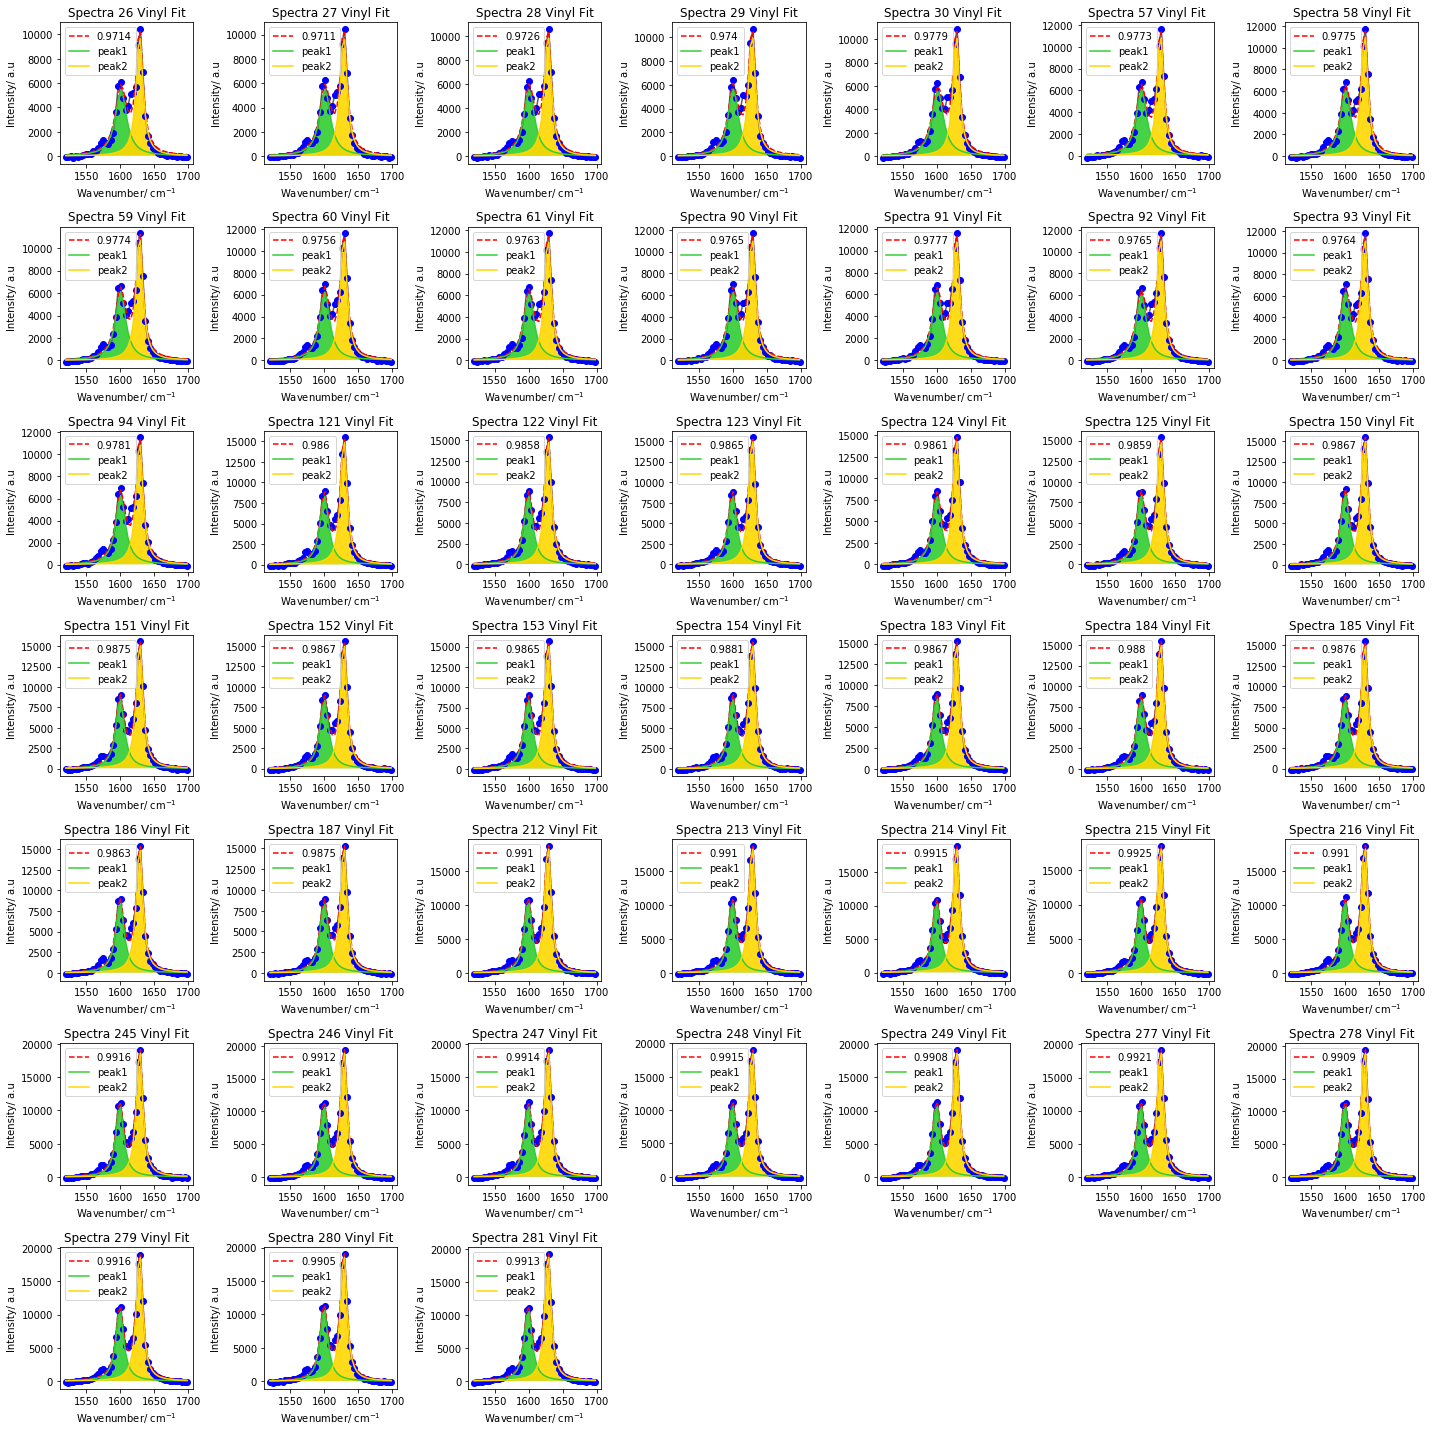

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (20,20))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(np.ceil(np.sqrt(df_vinyl.shape[0])),np.ceil(np.sqrt(df_vinyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

,ampL1,ampL2,cenL1,cenL2,widL1,widL2,R2_Vinyl,FWHM_L1,FWHM_L2,Height_L1,Height_L2
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,203424.678475,272989.724560,1599.931586,1628.396644,7.935299,5.662538,0.984625,15.870598,11.325077,8408.261461,15460.811050
std,25869.633687,54673.872860,0.565617,0.053130,1.030090,0.201727,0.006767,2.060181,0.403454,2027.103809,3560.813788
min,162632.893186,188695.047057,1599.309399,1628.274824,6.779897,5.371941,0.971139,13.559793,10.743881,5423.816958,10107.845490
25%,176409.297612,213059.277689,1599.439435,1628.348176,6.950704,5.502594,0.977467,13.901408,11.005188,6235.932821,11524.890865
50%,203041.418878,276174.747906,1599.738443,1628.401241,7.635199,5.611780,0.986676,15.270397,11.223561,8440.173015,15679.375429
75%,232382.897692,332949.504701,1600.460534,1628.431732,8.936565,5.800487,0.990959,17.873131,11.600974,10634.175452,19298.585781
max,239382.506144,342528.924084,1601.222015,1628.496645,10.096951,6.094068,0.992456,20.193902,12.188135,11101.252589,20134.778009


For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

,Original Index,Condition,Vinyl Peak Area,R2_Vinyl
0,26,19,181358.733174,0.971358
1,27,19,184601.921797,0.971139
2,28,19,187954.313595,0.972636
3,29,19,191309.358846,0.973952
4,30,19,180684.088879,0.977947
5,57,20,196570.972194,0.977286
6,58,20,199191.500776,0.977467
7,59,20,201328.120307,0.977448
8,60,20,203599.434227,0.975588
9,61,20,200602.932920,0.976315


# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

,743.107581,747.235957,751.364423,755.490999,759.613705,763.734525,767.853459,771.968532,776.081725,780.193037,...,821.175539,825.258412,829.341392,833.422514,837.501780,841.577229,845.650826,849.720613,853.788551,857.854643
0,529.0,437.0,360.0,418.0,506.0,716.0,1357.0,2362.0,2103.0,1227.0,...,6414.0,10767.0,10806.0,6076.0,2387.0,1115.0,659.0,412.0,340.0,258.0
1,576.0,501.0,416.0,415.0,516.0,811.0,1371.0,2379.0,2291.0,1195.0,...,6271.0,10652.0,10806.0,6125.0,2380.0,1091.0,567.0,397.0,411.0,320.0
2,544.0,439.0,398.0,449.0,508.0,708.0,1413.0,2309.0,2193.0,1255.0,...,6365.0,10763.0,10815.0,6065.0,2271.0,1087.0,624.0,421.0,335.0,260.0
3,562.0,417.0,376.0,427.0,454.0,767.0,1326.0,2322.0,2034.0,1213.0,...,6298.0,10730.0,10772.0,6123.0,2288.0,1092.0,571.0,441.0,437.0,249.0
4,545.0,502.0,415.0,469.0,540.0,745.0,1454.0,2298.0,2177.0,1145.0,...,6395.0,10799.0,10954.0,5994.0,2401.0,1070.0,586.0,468.0,390.0,323.0
5,496.0,417.0,352.0,453.0,490.0,771.0,1347.0,2479.0,2321.0,1195.0,...,6084.0,10417.0,10255.0,5509.0,2205.0,928.0,476.0,414.0,292.0,243.0
6,499.0,376.0,333.0,439.0,488.0,752.0,1421.0,2539.0,2284.0,1199.0,...,6090.0,10313.0,10250.0,5676.0,2183.0,986.0,581.0,356.0,366.0,230.0
7,506.0,432.0,430.0,401.0,411.0,745.0,1473.0,2469.0,2323.0,1288.0,...,6139.0,10379.0,10443.0,5720.0,2090.0,984.0,530.0,431.0,320.0,256.0
8,558.0,438.0,306.0,426.0,415.0,752.0,1436.0,2364.0,2325.0,1231.0,...,6124.0,10342.0,10550.0,5707.0,2282.0,956.0,522.0,360.0,332.0,213.0
9,506.0,397.0,337.0,413.0,432.0,721.0,1459.0,2394.0,2103.0,1310.0,...,6030.0,10266.0,10287.0,5644.0,2162.0,979.0,477.0,330.0,336.0,255.0


In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 20000
cenL1 = 772 
widL1 = 3

ampL2 = 25000 
cenL2 = 808
widL2 = 5

ampL3 = 100000
cenL3 = 826
widL3 = 6
widL4 = 4

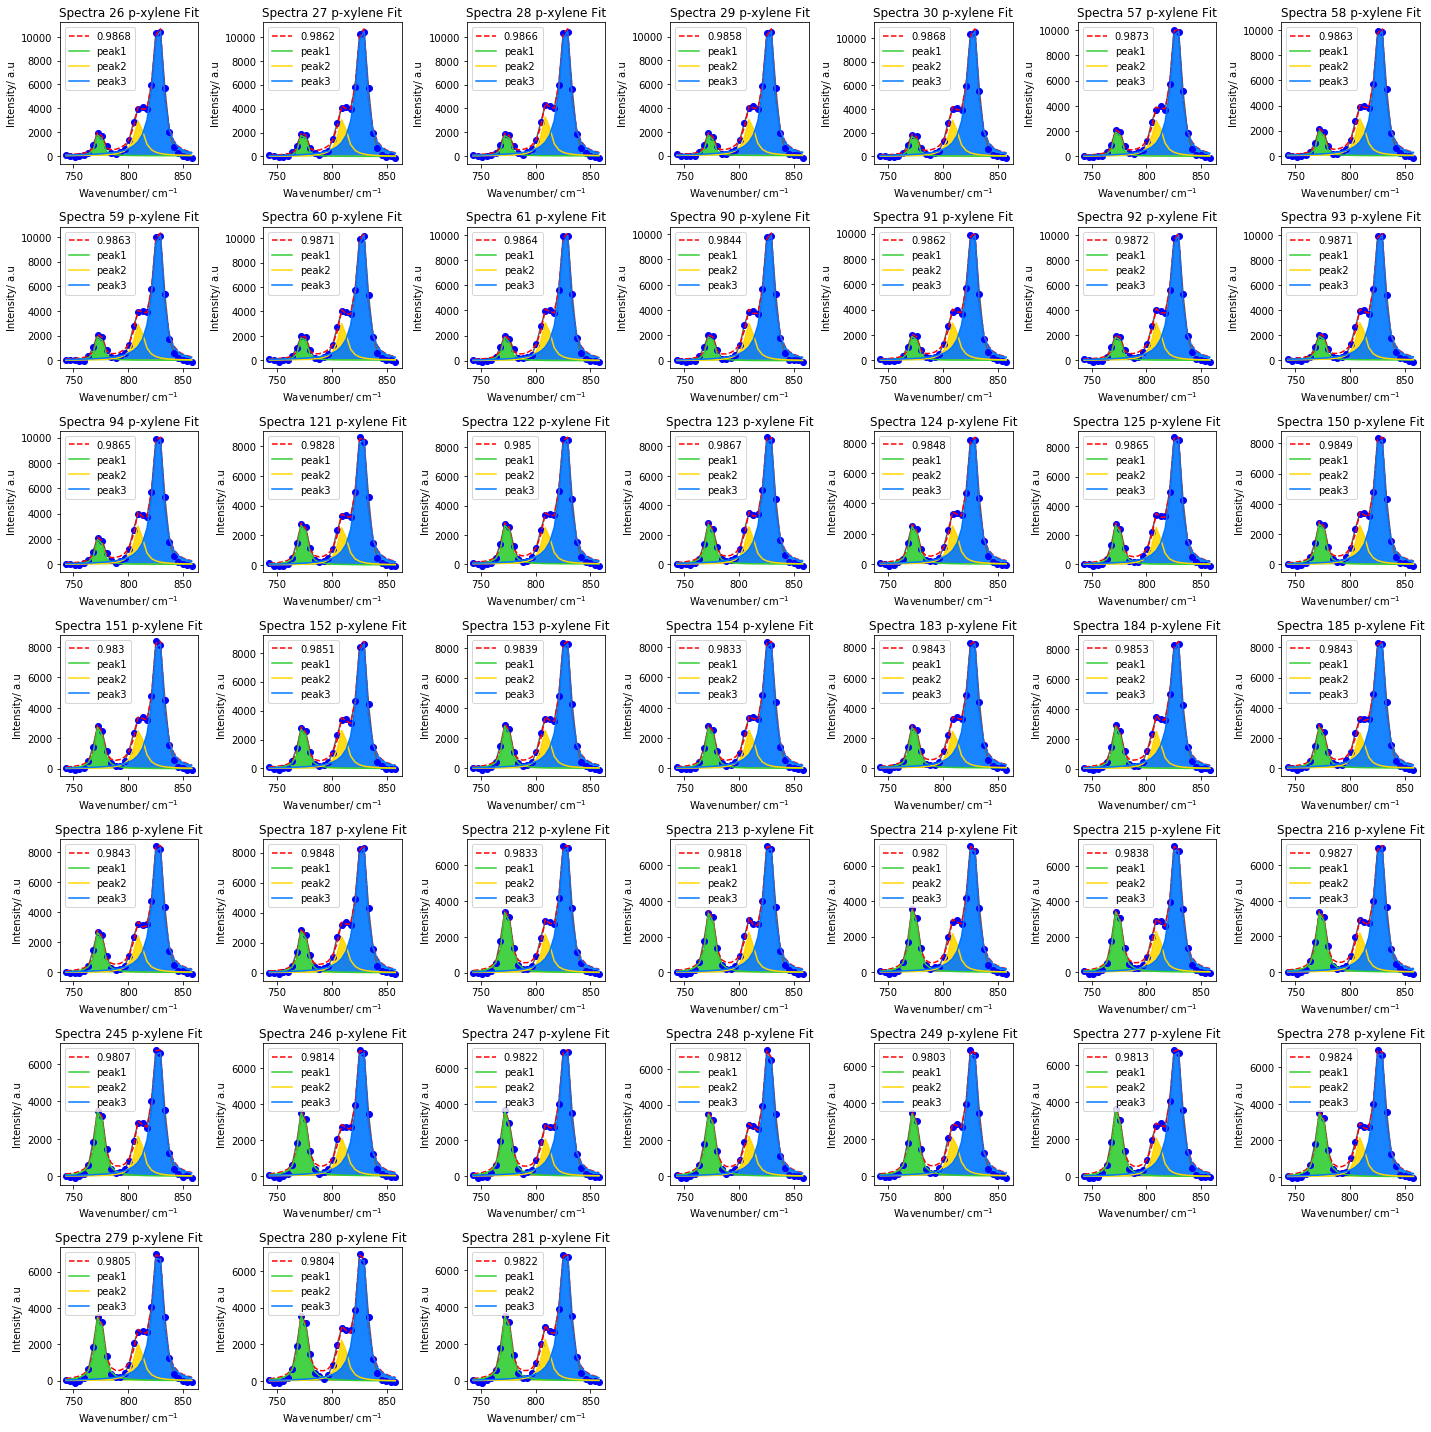

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (20,20))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(np.ceil(np.sqrt(df_pxyl.shape[0])),np.ceil(np.sqrt(df_pxyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

,ampL1,ampL2,ampL3,cenL1,cenL2,cenL3,widL1,widL2,widL3,widL4,R2_pxyl,FWHM_L1,FWHM_L2,FWHM_L3,Height_L1,Height_L2,Height_L3
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,36559.194551,40635.563789,159118.037187,773.675916,809.755819,827.758798,3.436957,4.924798,6.216527,4.514183,0.984273,6.873914,9.849597,10.730709,3312.104465,2622.402528,4714.850062
std,11164.218657,6227.853380,26025.312388,0.116307,0.158637,0.128766,0.468089,0.176682,0.194140,0.066372,0.002187,0.936177,0.353365,0.199964,624.950716,363.256245,734.464323
min,20291.035778,31019.841834,124435.190544,773.317864,809.335447,827.371746,2.454065,4.571866,5.684054,4.380925,0.980259,4.908131,9.143731,10.234801,2281.704517,2050.614115,3745.065167
25%,24257.469931,34837.431546,131085.066877,773.603965,809.662550,827.685401,3.022681,4.784774,6.128203,4.473024,0.982357,6.045361,9.569547,10.640420,2664.522782,2279.236831,3913.898747
50%,36860.354029,39757.642976,157022.042650,773.677547,809.784561,827.776121,3.566819,4.920583,6.224299,4.507869,0.984442,7.133637,9.841166,10.738141,3316.671054,2577.803923,4645.125047
75%,48515.955911,47744.121561,186448.216507,773.748856,809.877130,827.853183,3.847430,5.054145,6.336941,4.570750,0.986343,7.694860,10.108289,10.854742,3993.080342,3002.244803,5510.396630
max,52048.117241,51101.292362,199542.521760,773.892850,810.022201,827.951142,4.074997,5.285878,6.692900,4.692742,0.987306,8.149993,10.571756,11.137872,4163.409819,3362.774138,5829.614894


In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

,Original Index,Condition,Vinyl Peak Area,R2_Vinyl,pxyl Peak Area,R2_pxyl
0,26,19,181358.733174,0.971358,187289.740129,0.986791
1,27,19,184601.921797,0.971139,185431.132562,0.986233
2,28,19,187954.313595,0.972636,185865.271327,0.986567
3,29,19,191309.358846,0.973952,184525.940821,0.985829
4,30,19,180684.088879,0.977947,185636.701793,0.986810
5,57,20,196570.972194,0.977286,173694.421759,0.987306
6,58,20,199191.500776,0.977467,175852.063660,0.986343
7,59,20,201328.120307,0.977448,178281.385485,0.986298
8,60,20,203599.434227,0.975588,180416.555726,0.987121
9,61,20,200602.932920,0.976315,175301.059056,0.986406


In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.96) & (df_area['R2_pxyl'] > 0.96)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

,Original Index,Condition,Vinyl Peak Area,R2_Vinyl,pxyl Peak Area,R2_pxyl,Vinyl Divide pxyl
0,26,19,181358.733174,0.971358,187289.740129,0.986791,0.968332
1,27,19,184601.921797,0.971139,185431.132562,0.986233,0.995528
2,28,19,187954.313595,0.972636,185865.271327,0.986567,1.011240
3,29,19,191309.358846,0.973952,184525.940821,0.985829,1.036761
4,30,19,180684.088879,0.977947,185636.701793,0.986810,0.973321
5,57,20,196570.972194,0.977286,173694.421759,0.987306,1.131706
6,58,20,199191.500776,0.977467,175852.063660,0.986343,1.132722
7,59,20,201328.120307,0.977448,178281.385485,0.986298,1.129272
8,60,20,203599.434227,0.975588,180416.555726,0.987121,1.128496
9,61,20,200602.932920,0.976315,175301.059056,0.986406,1.144334


In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
19                      5.0  0.997036  0.028144  0.968332  0.973321  0.995528   
20                      5.0  1.133306  0.006402  1.128496  1.129272  1.131706   
21                      5.0  1.162405  0.008200  1.151064  1.156269  1.167699   
22                      5.0  1.734748  0.010481  1.719839  1.731556  1.734495   
23                      5.0  1.839062  0.018182  1.821000  1.826976  1.830127   
24                      5.0  1.776108  0.023910  1.741836  1.760519  1.788200   
25                      5.0  2.587468  0.039615  2.556727  2.562640  2.567327   
26                      5.0  2.728628  0.041449  2.659192  2.721801  2.747931   
27                      5.0  2.734352  0.039688  2.693082  2.707325  2.728916   

                               
                75%       max  
Condition                      
19         1.011240  1.036761  
20         1.132722  1.144334  
21         1.168024  1.168970  
22         1.739542  1.748309  
23         1.856809  1.860400  
24         1.792793  1.797194  
25         2.598452  2.652196  
26         2.754936  2.759279  
27         2.747559  2.794875

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = range(19,28)

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio

,Condition,Mean Ratio,Standard Deviation
0,19,0.997036,0.028144
1,20,1.133306,0.006402
2,21,1.162405,0.008200
3,22,1.734748,0.010481
4,23,1.839062,0.018182
5,24,1.776108,0.023910
6,25,2.587468,0.039615
7,26,2.728628,0.041449
8,27,2.734352,0.039688


In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\201022 High Throughput Experiment Conditions 19 to 27\Online Raman\df_t0_ratio_repeat.csv')